# Unsupervised Clustering for Synthetical Volume Generation

* Estimate the cummulative variance threshold needed to reproduce a fidel representation of the image
* Estimate the number of principal components necessary for that threshold, for images sampled from lower abdomen, lung and neck areas
* Establish a stable number of Clusters by applying DBSCAN from CLUSTERS = POINTS to CLUSTERS = 1 and determining the constant number of clusters
* Apply KMeans with the number of clusters established before
* Plot the clusters given by KMeans for qualitative evaluation

In [1]:
from monai.apps import DecathlonDataset
from monai.data import DataLoader
import os
from monai.transforms import (
    LoadImageD,
    EnsureChannelFirstD,
    Compose,
    OrientationD,
)
import random
import matplotlib.pyplot as plt
import torch
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm import tqdm
from sklearn.cluster import DBSCAN, KMeans

In [2]:
random.seed(0)

In [3]:
crt_dir = os.getcwd()
datasets_path = f'{crt_dir}/datasets/MSD/MedicalDecathlon/'
datasets_path

'/home/aimas/Desktop/Hackathon_Enfield/datasets/MSD/MedicalDecathlon/'

In [4]:
base_transform = Compose([
    LoadImageD(keys=["image", "label"]),
    EnsureChannelFirstD(keys=["image", "label"]),
    OrientationD(keys=["image", "label"], axcodes='RAS'),
])

In [5]:
train_dataset = DecathlonDataset(root_dir = datasets_path,
                        task = "Task06_Lung", section = "training",
                        transform = base_transform, download = False)

Loading dataset: 100%|██████████| 51/51 [03:29<00:00,  4.10s/it]


In [6]:
from eda_src.plots_aggregative_eda import render_image

In [7]:
pacient = train_dataset[0]
print(pacient['image'].shape)

torch.Size([1, 512, 512, 589])


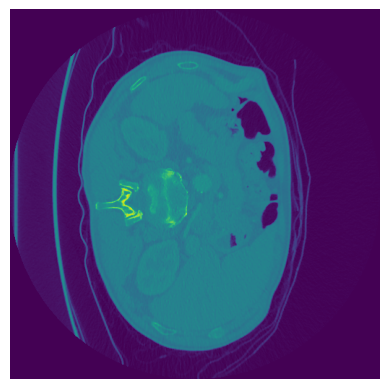

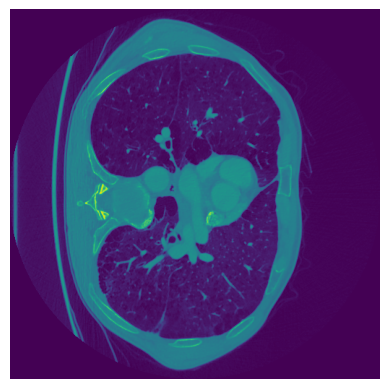

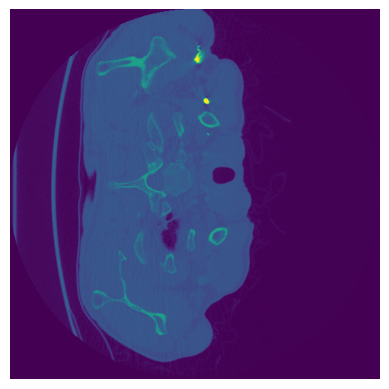

In [8]:
abdomen = pacient['image'][0, ..., 50]
lungs = pacient['image'][0, ..., 300]
neck = pacient['image'][0, ..., 550]


render_image(pacient['image'], 50)
render_image(pacient['image'], 300)
render_image(pacient['image'], 550)

# Treating Var Threshold as a hyperparameter

* Have tested: Var threshold = (90 -> 6 PC, 97.5 -> 28 PC, 98 -> 33 PC, 99 -> 50 PC, 99.5 -> 72 PC)

* Best trade-off between number of PC and image quality is: 99


In [9]:
from eda_src.normalization import min_max_normalization
from eda_src.pca_funcs import plot_pca_analysis, calculate_mean_components, get_patients_pca_components

torch.Size([512, 512])
metatensor(1.)
Number of components explaining 99% variance: 50


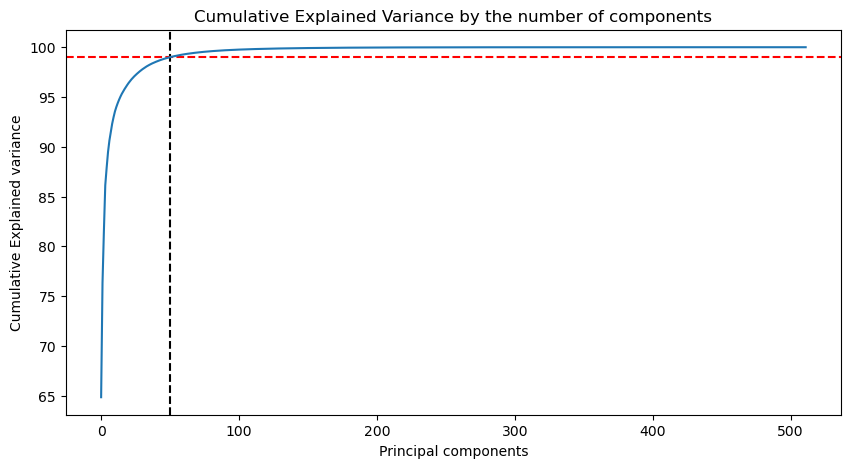

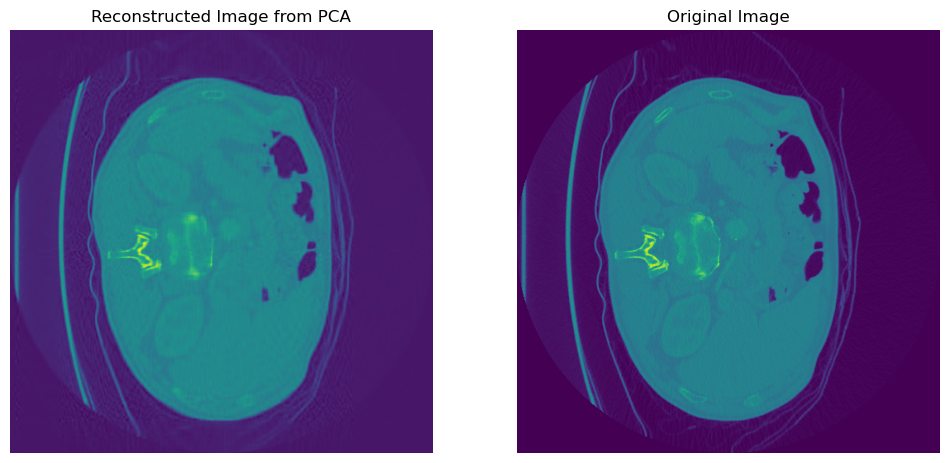

In [10]:
plot_pca_analysis(abdomen, 99)

# Treating No of Principal Components as the hyperparameter

* We chosed 3 random patients and averaged the number of PC needed for 99% variation

* The mean is 155.645, we truncated to 150 components to be taken further for Clusterization for each slice

In [11]:
rand_idx = [ ]

for i in range(3):
    next_idx = random.randint(0, len(train_dataset) - 1)
    if next_idx in rand_idx:
        continue
    rand_idx.append(next_idx)

rand_train = []

for idx in rand_idx:
    rand_train.append(train_dataset[idx])
    
rand_idx

[24, 48, 26]

In [12]:
rand_train[0]['image'].shape

torch.Size([1, 512, 512, 251])

In [13]:
components = calculate_mean_components(rand_train)

100%|██████████| 3/3 [09:44<00:00, 194.86s/it]


In [14]:
len(components)

758

In [15]:
np.array(components).mean()

108.14775725593668

# Applyin Clustering Methods on those patients

In [16]:
components_patient_info = get_patients_pca_components(rand_train, rand_idx)

100%|██████████| 241/241 [03:24<00:00,  1.18it/s]
3it [11:08, 222.89s/it]


In [18]:
from eda_src.clustering_funcs import apply_clustering, apply_kmeans

In [19]:
dbscan = apply_clustering(components_patient_info, eps = 4)

np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [ ]:

# No clusters per distance

# < 0.5 => 1
# 0.7 => 6
# [0.8, 0.9] => 14
# [1, 2.5] => 18
# 3 => 5
# 4 => 2
# > 4 => 1


# 5, 10, 15, 20

In [20]:
NO_CLUSTERS = 5

kmeans = apply_kmeans(components_patient_info, NO_CLUSTERS)

In [21]:
def plot_clusters(components_patient_info, NO_CLUSTERS, NO_IMAGES = 6):
    fig, axes = plt.subplots(NO_CLUSTERS, NO_IMAGES, figsize=[20, 5])

    for i in range(NO_CLUSTERS):
        label_indices = np.nonzero(kmeans.labels_ == i)

        # Randomly select NO_IMAGES images from the cluster
        random_indices = random.sample(list(label_indices[0]), NO_IMAGES)

        # Put the title to the left
        axes[i, 0].yaxis.set_label_position("left")
        axes[i, 0].set_ylabel(f'Cluster {i}')


        for j, idx in enumerate(random_indices):
            # print(components_patient_info[idx][0])
            img = train_dataset[components_patient_info[idx][0]]['image'].squeeze(0)[..., components_patient_info[idx][1]]
            axes[i, j].imshow(img, cmap='gray')
            # axes[i, j].set_title(f'Cluster {i} - Image {j}')
            axes[i, j].set_axis_off()
        
    plt.tight_layout()
    plt.show()

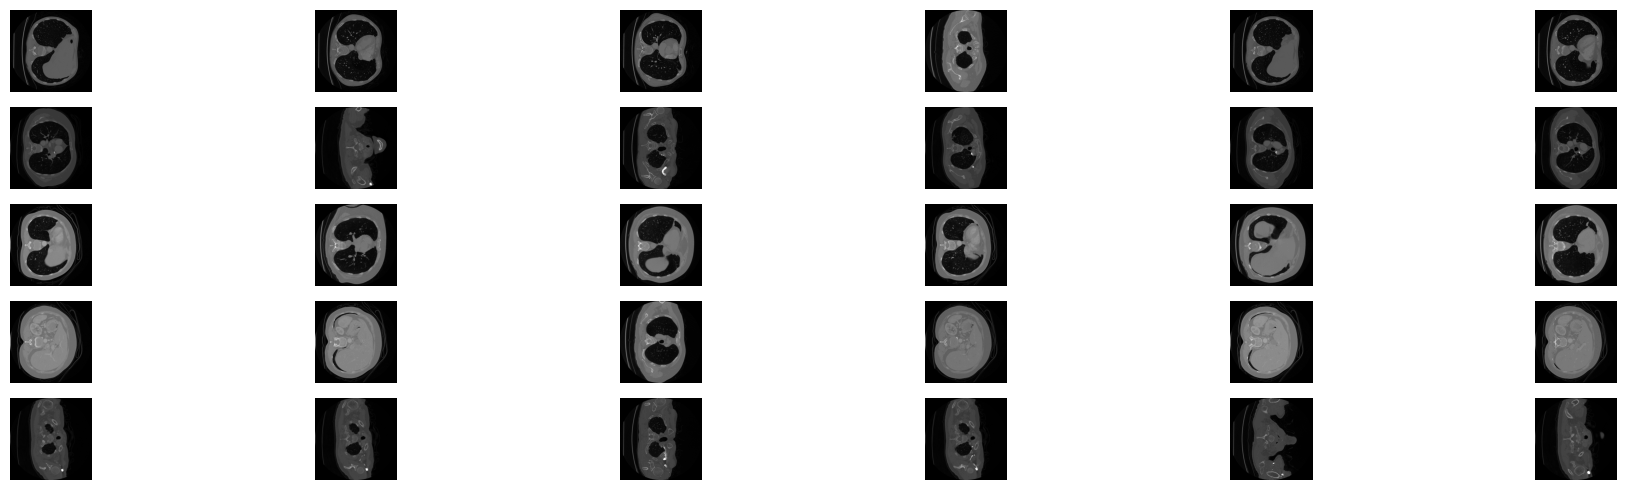

In [23]:
plot_clusters(components_patient_info, NO_CLUSTERS)

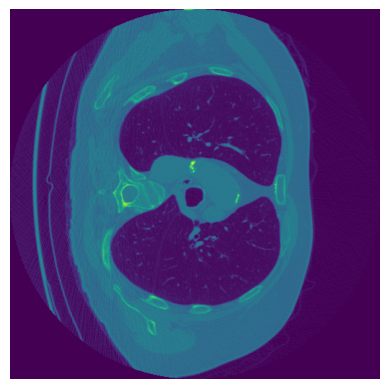

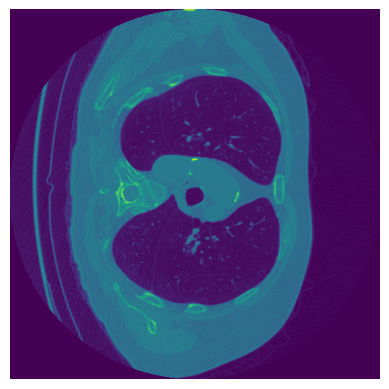

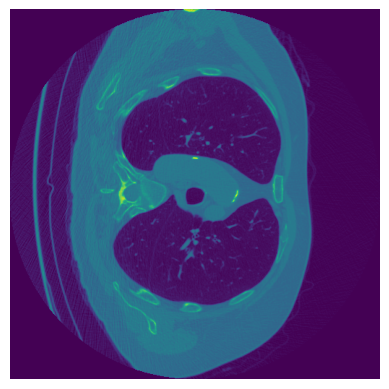

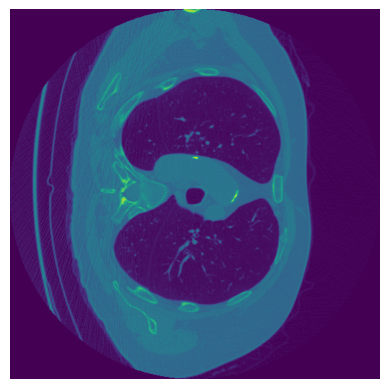

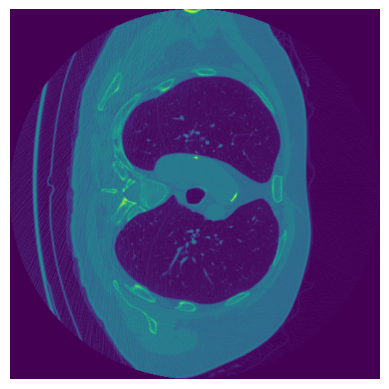

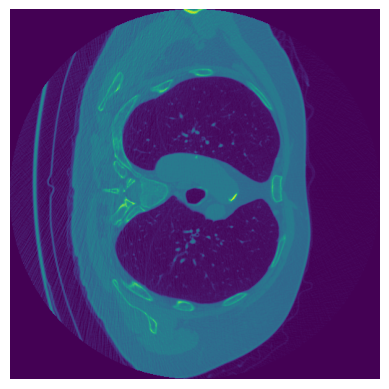

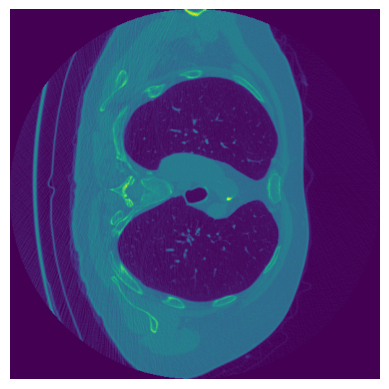

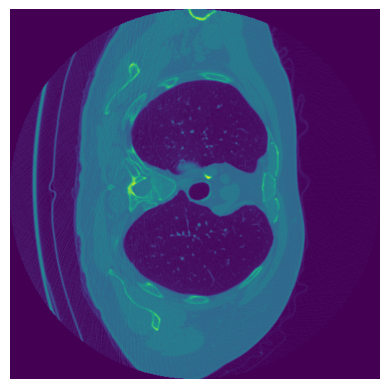

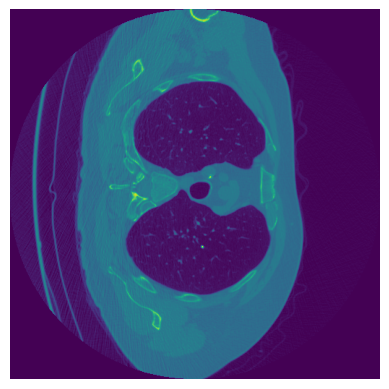

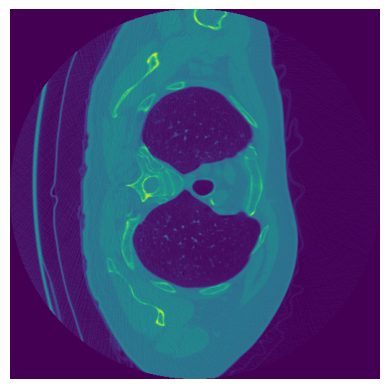

In [25]:
# components_patient_info = np.array(components_patient_info)
# X = components_patient_info[kmeans.labels_ == 1]
label_indices = np.nonzero(kmeans.labels_ == 0)

max_images = 10

for idx in label_indices[0]:
    img = train_dataset[components_patient_info[idx][0]]['image']
    render_image(img, components_patient_info[idx][1])

    max_images -= 1
    if max_images == 0:
        break